# Higher Order Stats for AMC 

We'll run through a very basic Decision Tree example from scikit learn.

In [1]:
import sys
sys.path.insert(0, "..")
from comms import awgn, modulate

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_data(num_examples, mod_order=4, sps=8, snr=50):
    
    span=8
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples))
    samples = modulate(ints, M=mod_order)
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    samples_noisy = awgn(samples_pulse_shaped, snr)
    
    return samples_noisy

def make_rrc(num_weights=41, alpha=0.35, fs=5):
    Ts =  1/fs
    
    # Calculate time indexes of filter weights
    x = np.arange(-int(num_weights/2),int(num_weights/2),1)/fs
    
    # Preallocate memory for filter weights
    h_rrc = np.zeros(num_weights,)

    # Check for special cases, otherwise apply the main formula
    for idx, weight in enumerate(x):
        if weight == Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == -Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == 0:
            h_rrc[int(num_weights/2)] = 1/Ts*(1+alpha*(4/np.pi - 1))
        else:
            h_rrc[idx] = 1/Ts*(np.sin(np.pi*weight*(1-alpha)) + 4*alpha*weight*np.cos(np.pi*weight*(1+alpha)))/(np.pi*weight*(1-(4*alpha*weight)**2))
            
    # Normalize the weights
    h_rrc = h_rrc/np.max(h_rrc)
    
    return h_rrc

def pulse_shape(symbols, hrrc, sps=4):
    
    num_weights = len(hrrc)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    # to take care of the transient we append a bunch of zeros
    shaped_symbols = np.convolve(np.concatenate((np.zeros(int((num_weights-1)/2)),padded_symbols)), hrrc, mode='same')
    
    return shaped_symbols[int((num_weights-1)/2):]

# add phase offset in degrees
def phase_offset(x, offset):
    
    # Convert to polar form so we can add degrees
    mag, ang = np.abs(x), np.angle(x, deg=True)
    
    return mag * np.exp( 1j * ((ang + offset)*np.pi/180) )

## Data

Let's generate 4 classes of modulations...

In [3]:
bpsk_symbols = gen_data(100, mod_order=2, sps=8, snr=30)
qpsk_symbols = gen_data(100, mod_order=4, sps=8, snr=30)
psk8_symbols = gen_data(100, mod_order=8, sps=8, snr=30)
qam16_symbols = gen_data(100, mod_order=16, sps=8, snr=30)

Visualize the modulated data. Most AMC algorithms treat this data as very long 2D images.

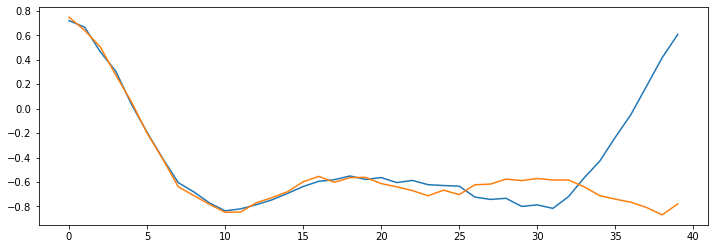

In [4]:
plt.figure(figsize=(12,4))
plt.plot(qpsk_symbols.real[:40])
plt.plot(qpsk_symbols.imag[:40])
# plt.savefig('for_drawing.svg')

We can plot these exactly as we would images, and could apply Conv2D layers exactly like computer vision people do for classifying cats.

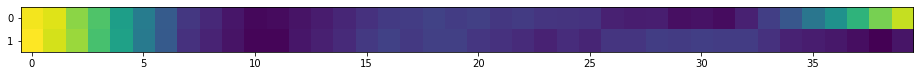

In [5]:
plt.figure(figsize=(16,4))
plt.imshow(np.vstack((qpsk_symbols.real[:40],qpsk_symbols.imag[:40])))

Text(0.5, 1.0, '16-QAM')

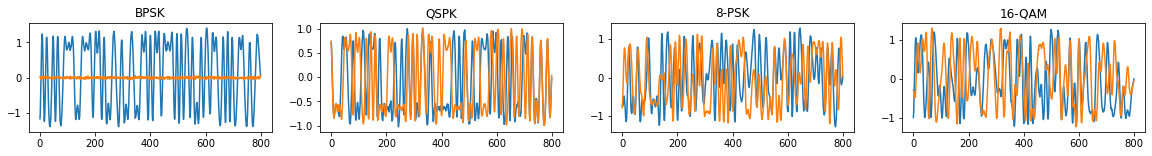

In [6]:
fig, ax = plt.subplots(1,4, figsize=(20,2))
ax[0].plot(bpsk_symbols.real)
ax[0].plot(bpsk_symbols.imag)
ax[0].set_title('BPSK')
ax[1].plot(qpsk_symbols.real)
ax[1].plot(qpsk_symbols.imag)
ax[1].set_title('QSPK')
ax[2].plot(psk8_symbols.real)
ax[2].plot(psk8_symbols.imag)
ax[2].set_title('8-PSK')
ax[3].plot(qam16_symbols.real)
ax[3].plot(qam16_symbols.imag)
ax[3].set_title('16-QAM')

## Higher Order Stats

In [7]:
def calc_moments(x):
    m2 = np.mean((x-np.mean(x))**2) 
    m3 = np.mean((x-np.mean(x))**3)/(np.mean((x-np.mean(x))**2)**(3/2))
    m4 = np.mean((x-np.mean(x))**4)/(np.mean((x-np.mean(x))**2)**(2))
    m5 = np.mean((x-np.mean(x))**5)/(np.mean((x-np.mean(x))**2)**(5/2))
    m6 = np.mean((x-np.mean(x))**6)/(np.mean((x-np.mean(x))**2)**(3))
    
    return m2, m3, m4, m5, m6

In [8]:
my_moments = calc_moments(np.abs(psk8_symbols))
my_moments

(0.05411633403738821,
 -0.8303065038686497,
 3.600416296861401,
 -7.196490897935278,
 23.95713700213137)

As a sanity check, let's make sure we're calculating moments correctly...

In [9]:
from scipy.stats import skew, kurtosis

In [10]:
my_moments[2] == kurtosis(np.abs(psk8_symbols))

False

Whaa? Why is our calculation wrong??

In [11]:
my_moments[2]

3.600416296861401

In [12]:
kurtosis(np.abs(psk8_symbols))

0.6004162968614009

Turns out Fisher's difinition is used by default in these libraries

In [13]:
my_moments[2] == kurtosis(np.abs(psk8_symbols))+3

True

In [14]:
my_moments[1] == skew(np.abs(psk8_symbols))

True

Ok looks like our moment calculation are good for the most part. Let's see how these statistical features help us separate out the modulations.

In [15]:
bpsk_symbols = gen_data(100, mod_order=2, sps=8, snr=30)
qpsk_symbols = gen_data(100, mod_order=4, sps=8, snr=30)
psk8_symbols = gen_data(100, mod_order=8, sps=8, snr=30)
qam16_symbols = gen_data(100, mod_order=16, sps=8, snr=30)

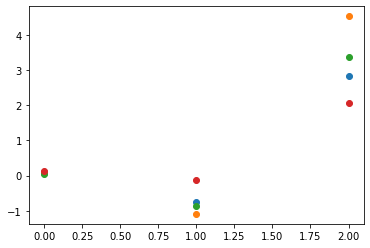

In [16]:
plt.plot(calc_moments(np.abs(bpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.abs(qpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.abs(psk8_symbols))[:3], 'o')
plt.plot(calc_moments(np.abs(qam16_symbols))[:3], 'o')

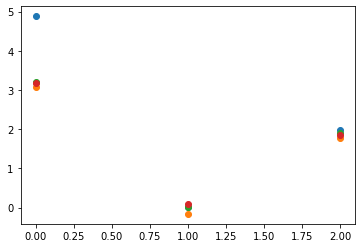

In [17]:
plt.plot(calc_moments(np.angle(bpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.angle(qpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.angle(psk8_symbols))[:3], 'o')
plt.plot(calc_moments(np.angle(qam16_symbols))[:3], 'o')

## Modulation distribution shapes

Looking at shapes can give us some insight as well. For example we can expect kurtosis to be larger for the QPSK data below than the 16-QAM dataset

Text(0, 0.5, 'Count')

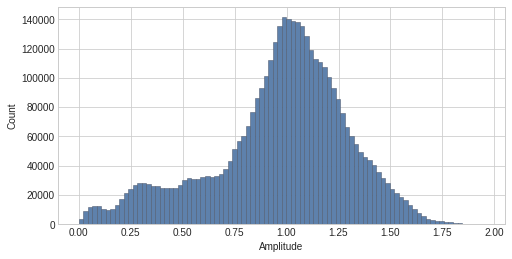

In [18]:
data = np.random.randint(0,4,1000000)
symbols = modulate(data, M=4, normalized=True)
rrc = make_rrc(num_weights=65)
symbols = pulse_shape(symbols, rrc, sps=4)
symbols = awgn(symbols,30)

plt.figure(figsize=(8,4)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean gridplt.hist(x, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)plt.title('Normal Distribution') 
plt.hist(np.abs(symbols), bins=90, facecolor = '#5e81ac', edgecolor='#4c566a', linewidth=0.5)
plt.xlabel('Amplitude') 
plt.ylabel('Count') 
# plt.savefig('figures/qpsk_abs_hist.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Count')

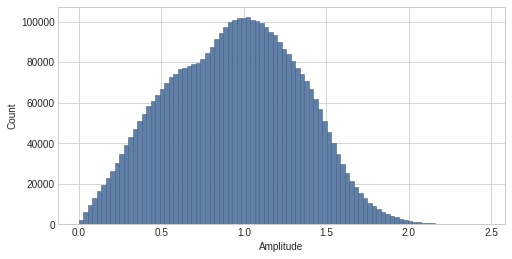

In [19]:
data = np.random.randint(0,16,1000000)
qam16_symbols = modulate(data, M=16, normalized=True)
rrc = make_rrc(num_weights=65)
qam16_symbols = pulse_shape(qam16_symbols, rrc, sps=4)
qam16_symbols = awgn(qam16_symbols,30)

plt.figure(figsize=(8,4)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean gridplt.hist(x, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)plt.title('Normal Distribution') 
plt.hist(np.abs(qam16_symbols), bins=90, facecolor = '#5e81ac', edgecolor='#4c566a', linewidth=0.5)
plt.xlabel('Amplitude') 
plt.ylabel('Count') 
# plt.savefig('figures/qam16_abs_hist.png', dpi=300, bbox_inches='tight')

In [20]:
calc_moments(np.abs(symbols))

(0.10924885149115787,
 -0.6091299272039192,
 3.196006008086966,
 -4.013350943059436,
 14.861341914575473)

In [21]:
calc_moments(np.abs(qam16_symbols))

(0.15568857374126963,
 -0.005776290187043627,
 2.405390419213071,
 0.31862059690351374,
 8.370932929994238)

Turns out correct, kurtosis ~3.2 for QPSK, ~2.4 for 16-QAM. That's one feature we could use to train a classifier.